# FERTILIZER RECOMMENDATION (CROP-CONDITIONED)

“Given `soil` + `weather` + selected `crop` → what fertilizer should be applied?”

### 1 . Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 8465
np.random.seed(RANDOM_STATE)


### 2 . Importing Data

In [2]:
df = pd.read_csv("../Crop_Yield_Fertilizer.csv")

In [3]:
print(df.shape)
df.head()

(25000, 10)


,N,P,K,temperature,humidity,ph,rainfall,label,yield,fertilizer
0,90.0,42.0,43.0,20.879744,82.002744,6.502985,202.935536,rice,71.199428,DAP
1,85.0,58.0,41.0,21.770462,80.319644,7.038096,226.655537,rice,81.620199,DAP
2,60.0,55.0,44.0,23.004459,82.320763,7.840207,263.964248,rice,80.473130,Gypsum
3,74.0,35.0,40.0,26.491096,80.158363,6.980401,242.864034,rice,75.178196,DAP
4,78.0,42.0,42.0,20.130175,81.604873,7.628473,262.717340,rice,75.485563,Gypsum


### 3 . Basic Data Cleaning

In [4]:
print("Crop distribution:\n", df['label'].value_counts().head())
print("\nFertilizer distribution:\n", df['fertilizer'].value_counts())


Crop distribution:
 label
orange         1196
kidneybeans    1180
papaya         1174
maize          1168
mungbean       1164
Name: count, dtype: int64

Fertilizer distribution:
 fertilizer
Urea                 14683
MOP                   5071
SSP                   2770
Lime                   957
DAP                    685
Rock Phosphate         368
Gypsum                 288
Rhizobium              148
Potassium Nitrate       30
Name: count, dtype: int64


### 4 . Feature Selection 

In [6]:
NUM_FEATURES = [
    'N', 'P', 'K',
    'temperature', 'humidity', 'ph', 'rainfall'
]

CAT_FEATURES = ['label']   # crop included

TARGET = 'fertilizer'

X = df[NUM_FEATURES + CAT_FEATURES]
y = df[TARGET]


### 5 . Encode Target (Fertilizers)

In [7]:
fertilizer_encoder = LabelEncoder()
y_encoded = fertilizer_encoder.fit_transform(y)

num_classes = len(fertilizer_encoder.classes_)
print("Number of fertilizer classes:", num_classes)


Number of fertilizer classes: 9


### 6 . Preprocessing Pipeline (Num + Cat)

In [8]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUM_FEATURES),
        ('cat', categorical_transformer, CAT_FEATURES)
    ]
)


### 7 . Model Configuration

In [9]:
model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    objective='multi:softprob',
    num_class=num_classes,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
    # n_jobs=-1
)


### 8 . Full Pipeline

In [10]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


### 9 . Stratified Train–Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=RANDOM_STATE
)


### 10 . Model Training

In [12]:
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 11 . Evaluation

In [13]:
y_pred = pipeline.predict(X_test)

print(classification_report(
    y_test,
    y_pred,
    target_names=fertilizer_encoder.classes_
))


                   precision    recall  f1-score   support

              DAP       0.88      0.89      0.89       137
           Gypsum       0.86      0.74      0.80        58
             Lime       0.80      0.83      0.81       191
              MOP       0.94      0.93      0.93      1014
Potassium Nitrate       0.00      0.00      0.00         6
        Rhizobium       0.77      0.80      0.79        30
   Rock Phosphate       0.70      0.70      0.70        73
              SSP       0.94      0.96      0.95       554
             Urea       0.99      0.99      0.99      2937

         accuracy                           0.96      5000
        macro avg       0.76      0.76      0.76      5000
     weighted avg       0.96      0.96      0.96      5000



C:\Users\preda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\preda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\preda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

We are able to find an Accuracy of `76`%

### 12 . Confusion Matrix

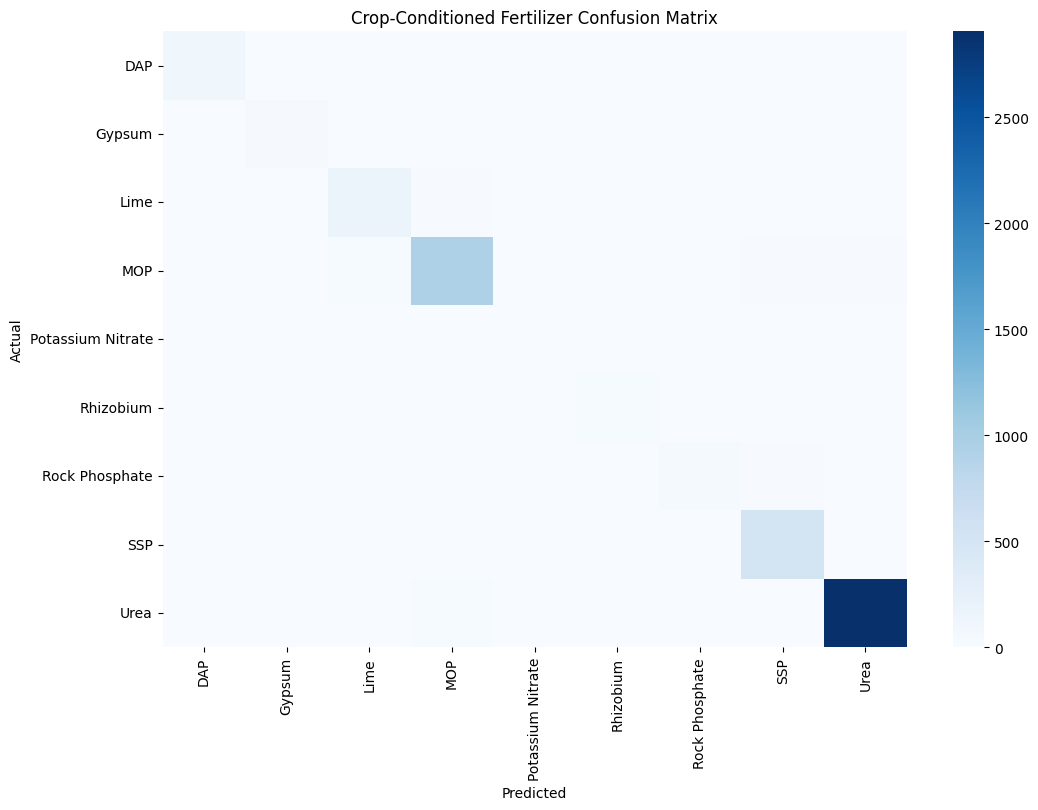

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=fertilizer_encoder.classes_,
    yticklabels=fertilizer_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Crop-Conditioned Fertilizer Confusion Matrix")
plt.show()


### Cross-Validation

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

macro_f1 = cross_val_score(
    pipeline,
    X,
    y_encoded,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

print("Macro F1 scores:", macro_f1)
print("Mean Macro F1:", macro_f1.mean())


Macro F1 scores: [0.75064097 0.74955326 0.75753337 0.75626356 0.77116741]
Mean Macro F1: 0.7570317154358204


### 14 . Inference Function

In [16]:
def recommend_fertilizer(input_dict):
    """
    input_dict example:
    {
        'N': 90,
        'P': 42,
        'K': 43,
        'temperature': 26,
        'humidity': 80,
        'ph': 6.5,
        'rainfall': 200,
        'label': 'rice'
    }
    """
    input_df = pd.DataFrame([input_dict])
    pred_encoded = pipeline.predict(input_df)[0]
    return fertilizer_encoder.inverse_transform([pred_encoded])[0]


### 15 . Example Prediction

In [18]:
sample_input = {
    'N': 23,
    'P': 45,
    'K': 4,
    'temperature': 2,
    'humidity': 50,
    'ph': 12.5,
    'rainfall': 300,
    'label': 'jute'
}

print("Recommended Fertilizer:", recommend_fertilizer(sample_input))


Recommended Fertilizer: Urea
